<table style="margin-left: 0; margin-right: auto;">  
    <tr>
        <td> <img src="Logo_NewCo_sm.png" width="250"/> </td>
    </tr>
</table>

# NOVIHUM's effect: effect on soil and yield

Andre Moreira

## Background

In 2019, we decided to collect Haney soil test data from several farm trials. This data was compiled in a dataset (here called "Haney_raw_data.csv"). In parallel to this dataset, we systematically collected, on a much larger scale, trial yields results. In other words, we had 2 distinct but overlapping databases with important data - one on NOVIHUM's effect on the soil, another with effect on the plant (using yield as a proxy). 

While the situation concerning 2 distinct datasets is not satisfactory, it is a common situation when it comes to data. Furthermore, the data can lead to important conclusions and therefore it is worth spending time and effort in bringing the data together and analyzing it.

## Summary of the results from this case study

- The data clearly shows that treated areas exhibit higher nutrient availability than control areas.

- The meta-analysis of the yield differences between treated and untreated areas across 891 trials shows:
    - An average yield increase of the treated sites of 21% versus control;
    - A median yield increase of 9%;
    - Win rate of 75%.

- Higher nutrient availability is not necessarily reflected in higher yields, as nutrients may be naturally or through fertilization already abundant enough. However in some cases the data shows a clear relationship between high yields and higher availability in treated areas.

- This data is the starting point of a deeper analysis (including collecting more data) that is necessary to clarify any further agronomic efects.


## Preamble

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind

from sklearn import linear_model
from sklearn.metrics import r2_score

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')  # optional: for ggplot-like style

%matplotlib inline

import seaborn as sns


In [2]:
# Suitable default display for floats
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
sns.set_style("whitegrid")

In [5]:
%%html
<style> table {float:left} </style>

### Upload the raw data

In [6]:
# Read the CSV file with the data

# Haney soil data
filename = 'Haney_raw_data.csv'
df_haney = pd.read_csv(filename)

# Yield database
filename = 'NH_Yield_DB_raw.csv'
df_yields = pd.read_csv(filename)

In [7]:
# Keep the raw data stored, make a copy that we will use for the analysis
df = df_haney.copy()

In [8]:
df_y = df_yields.copy()

In [9]:
df.shape

(161, 71)

In [10]:
df_y.shape

(1175, 62)

In [11]:
df.head(3)

,Original name,Name (key),Crop,Stage,Treatment,Rate (lb/ac),Rate (note),Sand-Silt-Clay,Sand-Silt-Clay (note),OM,pH,Nitrate N,Po4P of pH < 6,Po4P of pH > 6,Potassium,Magnesium,Calcium,Sulfur,Zinc,Manganese,Copper,Iron,Boron,Potassium (CEC),Magnesium (CEC),Calcium (CEC),Sodium (cation) (CEC),Hydrogen (cation) (CEC),Total CEC (CEC),SO4 (conductivity),Chlorine (conductivity),Sodium (conductivity),EC (conductivity),Fizz Test (conductivity),Water Soluble Carbon,H2O Capacity %,Orthophosphate-p (H3A Extraction),Phosphorous (H3A Extraction),Potassium (H3A Extraction),Magnesium (H3A Extraction),Calcium (H3A Extraction),Sodium (H3A Extraction),Iron (H3A Extraction),Aluminum (H3A Extraction),Nitrate (WSE),Ammonical Nitogen (WSE),Orthophosphate-P (WSE),Carbon (WSE),Total Nitrogen (WSE),CO2C Burst (Haney),Organic carbon (Haney),Organic nitrogen (Haney),Organic C/N ration (Haney),Haney Test,Nitrogen Credit via Haney,Alternaria (Pathogen),Collectotrichum (Pathogen),Clindrocarpon (Pathogen),Fusarium (Pathogen),Phytophthora (Pathogen),Pythium (Pathogen),Rhizoctonia (Pathogen),Stemphyllium (Pathogen),Verticillium (Beneficial),Macrophomina (Beneficial),Bptryosphaeria sp. (Beneficial),Aspergillus (Beneficial),Cladosporium (Beneficial),Penicillium (Beneficial),Rhizopus (Beneficial),Trichoderma (Beneficial)
0,Mission Spinach 8/5/19,Mission,Spinach,Pre-Novium Aplication,Control,0.00,NaN,51-26-23,NaN,2.80,6.80,19.80,NaN,16.80,233.40,579.30,"2,298.90",58.5,0.7,48.70,1.60,35.80,1.40,3.30,26.90,64.10,3.5,2,17.60,175.5,51.9,146.4,0.80,1,NaN,54.70,127.7,138.00,107.00,196.00,567.00,116.00,54.00,136.00,31.00,1.00,7.44,82.80,37.00,37.00,82.80,5.00,16.60,5.00,12.00,ND,ND,ND,++,ND,+,+,ND,ND,NaN,NaN,+,ND,++,ND,ND
1,Mission Spinach 9/10/19,Mission,Spinach,Mid-Growth,Control,0.00,NaN,46-30-24,NaN,2.00,6.30,63.00,NaN,28.80,120.90,436.20,"1,744.50",21.7,0.5,39.90,1.50,23.30,0.70,2.20,25.90,62.00,2.8,7,13.10,65.1,19.4,93.1,0.70,1,64.10,41.20,85.2,96.00,87.00,150.00,468.00,86.00,37.00,86.00,66.00,1.80,8.82,64.10,71.60,28.00,64.10,3.80,16.90,3.80,11.00,ND,ND,ND,++,ND,+,ND,ND,ND,NaN,NaN,++,ND,++,+,ND
2,Mission Spinach 9/16/19,Mission,Spinach,Harvest,Control,0.00,NaN,50-28-22,NaN,2.40,6.90,12.60,NaN,24.30,170.30,406.00,"1,387.90",13.3,0,18.60,1.30,35.30,0.70,3.90,30.50,62.50,2,1,11.00,39.9,9.6,53.1,0.40,1,90.50,42.60,114.4,116.00,115.00,169.00,469.00,66.00,50.00,103.00,11.00,1.80,9.44,90.50,16.50,65.00,90.50,3.70,24.50,7.80,11.00,ND,ND,ND,+,ND,ND,++,ND,ND,NaN,NaN,+,ND,+,+++,ND


# Analysis - soil (Haney)

In [12]:
# let us list the farms that were part of the Haney soil tests trial 
Names = df['Name (key)'].unique()
Names

array(['Mission', 'Mellon', 'Crain', 'JV', 'Kalin', 'Justin', 'Mid South',
       'Hall', 'Mathews', 'Sunridge', 'Surdul', 'Cherry', 'Wente',
       'Booth', 'Allen', 'Triangle', 'Creekside', 'Kreps', 'Wine'],
      dtype=object)

In [13]:
# Extract the averages and reative changes for each single trial

i = 1 # this will count the number of single trials
df_avs = pd.DataFrame() # set a DF to store the average results of a trial
df_avs_all = pd.DataFrame()
df_rel = pd.DataFrame()

# Auxiliary DFs for better code readability
Names = df['Name (key)'].unique() # extract the single farms
aux_1 = pd.DataFrame()
aux_2 = pd.DataFrame()
aux_3 = pd.DataFrame()

for j in Names:
    farm = "'" + j + "'"
    # first we filter the specific farm and check how many crops
    crops = df.query(f"`Name (key)` == {farm}")['Crop'].unique() # list of crops tested as a trial at a given farm
    
    for k in crops:
        # query the DF for a trial, separate in N and Control results 
        cr = "'" + k + "'"
        df_N = df.query(f"`Name (key)` == {farm} & Crop == {cr} & Treatment == 'Novihum'") # the NH data
        df_C = df.query(f"`Name (key)` == {farm} & Crop == {cr} & Treatment == 'Control'") # the control data      
        
        # get the mean values (write this extra steap only for better code readability)
        aux_3['0'] = pd.DataFrame(df_N.mean(axis = 0, skipna = True, numeric_only=True), columns=[f"trial {i} N"])
        aux_3['1'] = pd.DataFrame(df_C.mean(axis = 0, skipna = True, numeric_only=True), columns=[f"trial {i} C"])
        
        df_avs[f"trial {i} N"] = aux_3['0']
        df_avs[f"trial {i} C"] = aux_3['1']
        
        # create an auxiliar DF to add the name and crop, concatenate and store the data in the final DF
        aux = pd.DataFrame({f"trial {i} N":[j,k], f"trial {i} C":[j,k]}, index = ["Farm", "Crop"])
        aux_2 = pd.concat([aux, df_avs], axis = 0, join = "outer", ignore_index = False)                     
        df_avs_all[[f"trial {i} N", f"trial {i} C"]] = aux_2[[f"trial {i} N", f"trial {i} C"]]
        
        # create a separet DF with the relative difference between N and Control (same steps as above)
        aux = pd.DataFrame({f"trial {i} rel %":[j,k]}, index = ["Farm", "Crop"])           
        aux_1[f"trial {i} rel %"] = ((aux_3['0'] / aux_3['1'])-1)*100 # result in percent
        aux_2 = pd.concat([aux, aux_1], join = "outer", ignore_index = False)
        df_rel[[f"trial {i} rel %"]] = aux_2[[f"trial {i} rel %"]]
        
        i = i + 1

In [14]:
# this is the dataframe with the averages
df_avs_all.head()

,trial 1 N,trial 1 C,trial 2 N,trial 2 C,trial 3 N,trial 3 C,trial 4 N,trial 4 C,trial 5 N,trial 5 C,trial 6 N,trial 6 C,trial 7 N,trial 7 C,trial 8 N,trial 8 C,trial 9 N,trial 9 C,trial 10 N,trial 10 C,trial 11 N,trial 11 C,trial 12 N,trial 12 C,trial 13 N,trial 13 C,trial 14 N,trial 14 C,trial 15 N,trial 15 C,trial 16 N,trial 16 C,trial 17 N,trial 17 C,trial 18 N,trial 18 C,trial 19 N,trial 19 C,trial 20 N,trial 20 C,trial 21 N,trial 21 C,trial 22 N,trial 22 C,trial 23 N,trial 23 C,trial 24 N,trial 24 C
Farm,Mission,Mission,Mission,Mission,Mellon,Mellon,Mellon,Mellon,Crain,Crain,Crain,Crain,JV,JV,JV,JV,Kalin,Kalin,Justin,Justin,Mid South,Mid South,Hall,Hall,Mathews,Mathews,Sunridge,Sunridge,Surdul,Surdul,Cherry,Cherry,Wente,Wente,Booth,Booth,Allen,Allen,Allen,Allen,Triangle,Triangle,Creekside,Creekside,Kreps,Kreps,Wine,Wine
Crop,Spinach,Spinach,Romaine,Romaine,Lettuce,Lettuce,Barley,Barley,Almond,Almond,Walnut,Walnut,Hemp,Hemp,Lettuce,Lettuce,Onion,Onion,Vineyards,Vineyards,Cotton,Cotton,Vineyards,Vineyards,Sweet potato,Sweet potato,Vineyards,Vineyards,Almods,Almods,Orchard,Orchard,Vineyards,Vineyards,Lemon,Lemon,Lemon,Lemon,Orange,Orange,Vineyards,Vineyards,Wine Grapes,Wine Grapes,Pistachio,Pistachio,Vineyards,Vineyards
Rate (lb/ac),700.00,0.00,700.00,0.00,700.00,0.00,700.00,0.00,950.00,0.00,950.00,0.00,700.00,0.00,700.00,0.00,525.00,0.00,777.67,0.00,700.00,0.00,"1,500.00",0.00,300.00,0.00,300.00,0.00,726.67,0.00,"1,200.00",0.00,920.00,0.00,600.00,0.00,"1,800.00",0.00,"1,200.00",0.00,"1,125.00",0.00,750.00,0.00,900.00,0.00,625.01,0.00
OM,1.79,2.11,1.97,2.00,3.00,2.60,1.80,1.60,4.45,5.10,3.62,2.80,1.30,1.40,2.73,2.87,1.83,1.70,3.27,3.37,1.96,2.15,4.90,4.50,1.78,1.60,2.30,2.10,1.40,1.07,1.50,1.50,5.60,4.70,1.20,1.70,7.55,7.75,3.37,3.37,1.60,1.70,3.30,4.00,1.60,1.10,1.45,1.50
pH,7.49,6.97,7.47,7.40,8.30,8.30,8.20,8.10,5.90,5.90,6.12,6.70,7.80,7.80,7.96,8.03,8.10,8.10,6.80,7.07,7.67,7.80,7.60,7.80,6.58,6.62,8.10,8.00,6.95,6.73,7.00,7.00,6.70,6.75,6.80,7.10,7.75,7.75,6.43,6.67,7.50,7.40,7.80,5.40,7.30,7.40,6.80,7.35


In [15]:
# some of the data is not useful, we will take it out of the analysis. 
# For instance: (for space reasons, show here only 10 entries)
df_avs_all.loc["Po4P of pH < 6"][0:10]

trial 1 N     NaN
trial 1 C     NaN
trial 2 N     NaN
trial 2 C     NaN
trial 3 N     NaN
trial 3 C     NaN
trial 4 N     NaN
trial 4 C     NaN
trial 5 N   17.60
trial 5 C    8.80
Name: Po4P of pH < 6, dtype: object

In [16]:
# These columns had too many NaNs to be useful in the follwoing analysis. We take them out.
lst = ["Po4P of pH < 6","Water Soluble Carbon","H2O Capacity %", "Hydrogen (cation) (CEC)"]

In [17]:
df_avs_all.drop(lst, inplace = True)
df_rel.drop(lst, inplace = True)

In [18]:
# this is the dataframe with the relative differences (parameter NH relative to parameter control)
df_rel.shape

(38, 24)

In [19]:
df_rel.head()

,trial 1 rel %,trial 2 rel %,trial 3 rel %,trial 4 rel %,trial 5 rel %,trial 6 rel %,trial 7 rel %,trial 8 rel %,trial 9 rel %,trial 10 rel %,trial 11 rel %,trial 12 rel %,trial 13 rel %,trial 14 rel %,trial 15 rel %,trial 16 rel %,trial 17 rel %,trial 18 rel %,trial 19 rel %,trial 20 rel %,trial 21 rel %,trial 22 rel %,trial 23 rel %,trial 24 rel %
Farm,Mission,Mission,Mellon,Mellon,Crain,Crain,JV,JV,Kalin,Justin,Mid South,Hall,Mathews,Sunridge,Surdul,Cherry,Wente,Booth,Allen,Allen,Triangle,Creekside,Kreps,Wine
Crop,Spinach,Romaine,Lettuce,Barley,Almond,Walnut,Hemp,Lettuce,Onion,Vineyards,Cotton,Vineyards,Sweet potato,Vineyards,Almods,Orchard,Vineyards,Lemon,Lemon,Orange,Vineyards,Wine Grapes,Pistachio,Vineyards
Rate (lb/ac),inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
OM,-15.54,-1.67,15.38,12.50,-12.75,29.46,-7.14,-4.82,7.84,-3.11,-8.79,8.89,11.46,9.52,31.25,0.00,19.15,-29.41,-2.58,0.00,-5.88,-17.50,45.45,-3.33
pH,7.38,0.90,0.00,1.23,0.00,-8.58,0.00,-0.95,0.00,-3.84,-1.71,-2.56,-0.50,1.25,3.22,0.00,-0.74,-4.23,0.00,-3.50,1.35,44.44,-1.35,-7.48


## Treatment effect: relative values of the several parameters in treated vs. control areas

In [20]:
# let us get a sense of how the parameters were affected by the treatment
# NB: these are in %%

av_rel_diffs = df_rel.iloc[4:,:].mean(axis = 1, skipna = True).sort_values(ascending = False)
av_rel_diffs[:]

Potassium (H3A Extraction)     72.50
Nitrate (WSE)                  66.34
Organic C/N ration (Haney)     51.66
Total Nitrogen (WSE)           51.14
Nitrate N                      39.19
Organic nitrogen (Haney)       36.37
Boron                          33.49
EC (conductivity)              30.31
Phosphorous (H3A Extraction)   21.89
Orthophosphate-P (WSE)         21.61
Magnesium (H3A Extraction)     11.49
Calcium (H3A Extraction)       11.01
Magnesium (CEC)                10.93
Nitrogen Credit via Haney      10.61
Sodium (H3A Extraction)        10.45
Potassium                       8.51
Fizz Test (conductivity)        8.46
Potassium (CEC)                 6.79
Total CEC (CEC)                 6.16
Aluminum (H3A Extraction)       5.87
Calcium                         5.02
CO2C Burst (Haney)              3.31
Manganese                       2.48
Ammonical Nitogen (WSE)         2.24
Magnesium                       1.58
pH                              1.01
Po4P of pH > 6                  0.97
H

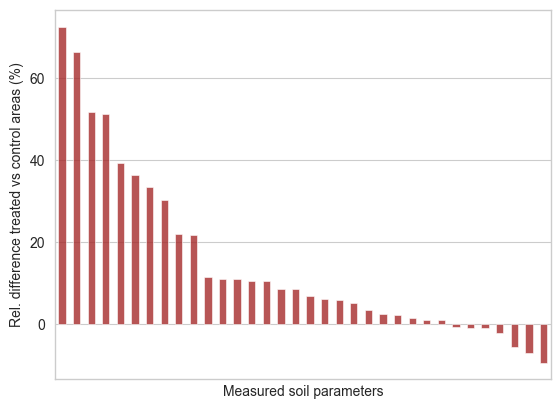

In [21]:
av_rel_diffs.plot(kind='bar', color = 'brown', alpha = 0.8, legend = False)
plt.xlabel("Measured soil parameters", fontsize=10)
plt.ylabel('Rel. difference treated vs control areas (%)', fontsize=10)
plt.xticks([])
plt.show()

### Conclusion: the vast majority of the soil parameters measured in treated areas showed higher values relative to the control areas. IN many cases, the effect is very pronounced with a difference of 20% or higher.

#### Notably, most parameters specific to nutrient extraction (see full list above) using organic acids extraction (simulating root interaction with the soil) were higher in treated than control areas.

## Soil organic matter

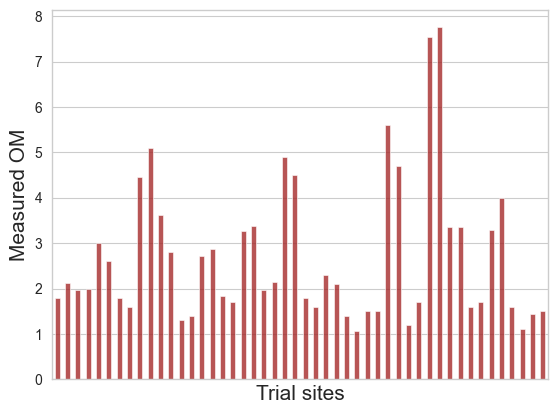

In [22]:
df_avs_all.loc["OM"].plot(kind='bar', color = 'brown', alpha = 0.8, legend = False)
plt.xlabel("Trial sites", fontsize=15)
plt.ylabel('Measured OM', fontsize=15)
plt.xticks([])
plt.show()

### Note that, generally speaking, the treated sites were not particularly poor in organic matter. This means that the treatment also shows effects in relatively good soils. 

## Nutrient availability: N, P and K

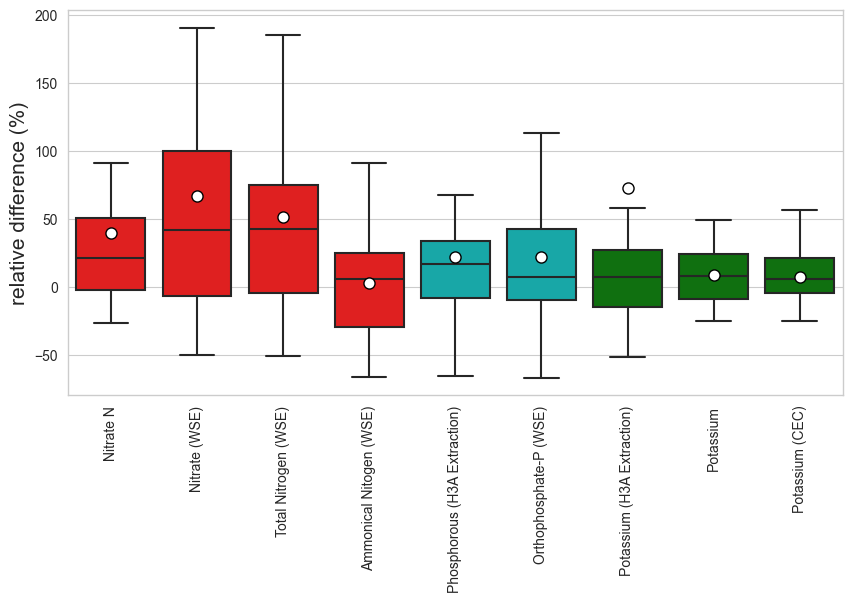

In [23]:
# Look at the difference in N between treated and control sites
lis = ["Nitrate N","Nitrate (WSE)","Total Nitrogen (WSE)", "Ammonical Nitogen (WSE)",
      "Phosphorous (H3A Extraction)","Orthophosphate-P (WSE)",
      "Potassium (H3A Extraction)","Potassium","Potassium (CEC)"]

df_pl = df_rel.loc[lis,:].transpose()

plt.figure(figsize=(10,5))
my_pal = {lis[0]:"r", lis[1]:"r", lis[2]:"r", lis[3]:"r", 
          lis[4]:"c", lis[5]:"c", 
          lis[6]:"g", lis[7]:"g", lis[8]:"g"} # color palette for the different macro-nutrients
sns.boxplot(df_pl, showfliers = False, showmeans=True, palette = my_pal,
           meanprops={'marker':'o',
                       'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'})           
plt.ylabel('relative difference (%)', fontsize=15)
plt.xticks(rotation=90)
plt.show()

###  There is a clear trend towards higher availability of the macro-nutrients in treated sites relative to control sites.

# Analysis: connect yield data with the soil test data

## First, a meta-analysis: relative yield difference between treated sites and control

In [24]:
# NB: the relative yield difference is a multiple (meaning e.g., 0.2 = 20% yield difference)
df_y[["Relative Yield difference"]].describe()

,Relative Yield difference
count,891.00
mean,0.21
std,0.61
min,-0.79
25%,0.00
50%,0.09
75%,0.28
max,14.22


### Conclusion: across 891 trials, the average yield increase of the treated sites is 21% versus control, with a median increase of 9% and a win rate of 75% (bottom quartile cuts at relative yield difference = 0).

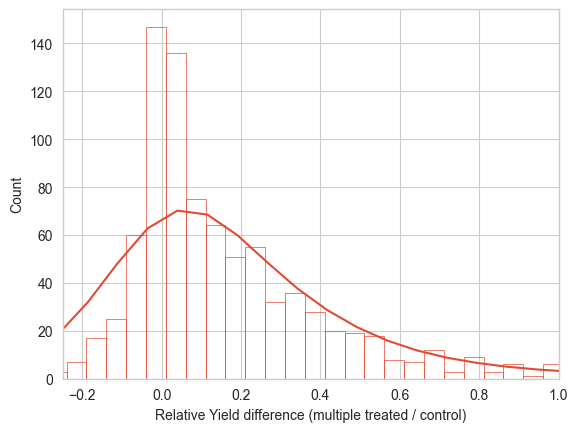

In [25]:
# check the yield distribution
fig, ax = plt.subplots()
sns.histplot(data = df_y, x = "Relative Yield difference", stat = 'count',
             kde = True,bins=300, discrete = False, fill = False, ax = ax)
ax.set_xlim(-.25, 1)
plt.xlabel("Relative Yield difference (multiple treated / control)")
plt.show()

### Find the common trials: soil and yield 

In [26]:
# How many unique farms were involved in the Haney soil test trials?
farm_list = df_rel.loc["Farm",:].unique()
print(farm_list)
print("total of ", len(farm_list),"farms involved")

['Mission' 'Mellon' 'Crain' 'JV' 'Kalin' 'Justin' 'Mid South' 'Hall'
 'Mathews' 'Sunridge' 'Surdul' 'Cherry' 'Wente' 'Booth' 'Allen' 'Triangle'
 'Creekside' 'Kreps' 'Wine']
total of  19 farms involved


There are only 20 farms. The second (yield) database is much larger, in this case the easiest and fastest option  to match the soil trials with yield information manually.

In [27]:
n = 0 # farm number (total of 20, numbered from 0 to 19)
# look for the farms from the soil trials in the larger yield database; see if the crops also match
match_n = farm_list[n] 
print(match_n)
print(df_rel.loc["Crop",:][df_rel.loc["Farm",:].str.contains(match_n)])

# check in the yields dataset if this farm is there, if yes show the trial crops
print(" ")
print(df_y[df_y["Operator"].str.contains(match_n)][["Operator", "Crop"]])

Mission
trial 1 rel %    Spinach
trial 2 rel %    Romaine
Name: Crop, dtype: object
 
          Operator            Crop
532  Mission Farms         Spinach
651  Mission Farms  Romain Lettuce


If there is a plausible match, add to the dictionary below. Note that because of the imperfection of the data, we need to make this procedure manually. 

In [28]:
# key: trial number from soil test trials; 
# item list: respective yield results for a certain crop at the respective farm
# matching key and items by hand in this case
dictionary = {
    1 : [532], 2: [651], 4: [1141], 5: [1116, 1121, 1122, 1123], 6: [1117, 1118, 1119, 1120], 
    8: [37, 38, 424], 9: [587, 588], 10: [598], 
     11:[607,608,609,610,611,612], 14:[1148], 15:[1149], 17:[1155], 18:[1115],
     19: [1112], 20: [1113], 21: [419, 420, 421, 422], 23:[1135,1136,1137]   
     }


In [29]:
# dataframe: combines trial results of relative yields and realtive Haney soil test results
# for clarity: this dataframe contains the relative parameters difference between treated and control sites
# e.g.: relative yield of a treated site vs. control; relative measured potassium of a treated site vs. control; etc.

matching = list(dictionary.items())
yield_list = []
aux_2 = pd.DataFrame()
df_comb = pd.DataFrame()
for i in matching:
    aux_2 = df_rel[[f"trial {i[0]} rel %"]] # respective trial being examined
    aux = []
    for j in i[1]:
        aux.append(df_y.loc[j,"Rel yield"]) # get a list of all measured yields for this trial
    res = np.mean(aux) # get the average yield
    # add the new row
    new_row = pd.DataFrame.from_dict({"Yield" : res}, orient='index', columns=[f"trial {i[0]} rel %"])
    aux_2 = pd.concat([new_row,aux_2], join = "outer", ignore_index = False)
    #print(aux_2)
    
    # store in the final df
    df_comb[[i[0]]] = aux_2[[f"trial {i[0]} rel %"]]
    #print(df_comb)

In [30]:
df_comb.head()

,1,2,4,5,6,8,9,10,11,14,15,17,18,19,20,21,23
Yield,0.25,-0.08,NaN,-0.03,-0.01,0.15,0.14,0.14,0.00,0.12,NaN,NaN,-0.03,NaN,0.17,0.16,NaN
Farm,Mission,Mission,Mellon,Crain,Crain,JV,Kalin,Justin,Mid South,Sunridge,Surdul,Wente,Booth,Allen,Allen,Triangle,Kreps
Crop,Spinach,Romaine,Barley,Almond,Walnut,Lettuce,Onion,Vineyards,Cotton,Vineyards,Almods,Vineyards,Lemon,Lemon,Orange,Vineyards,Pistachio
Rate (lb/ac),inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
OM,-15.54,-1.67,12.50,-12.75,29.46,-4.82,7.84,-3.11,-8.79,9.52,31.25,19.15,-29.41,-2.58,0.00,-5.88,45.45


## Look into the relationship between 

### a) yield: relative difference between treated and control areas and

### b) nutrient / soil parameters: relative difference between treated and control areas

In [31]:
# we will need this function a few times in our analysis

def plA (r1, r2):
#r1 = "Yield"
#r2 = "Nitrate (WSE)" # can be any of the soil parameters
    w_df = pd.DataFrame()
    w_df = df_comb.T[[r1,r2]].copy()
    w_df.reset_index(inplace=True, drop=True)
    w_df.dropna(axis=0, how="any",inplace=True)
    w_df = w_df.astype(float)

    df_pl = df_rel.loc[r2,:].T

    fig, axa = plt.subplots(ncols = 2, figsize = (8,3))
    fig.tight_layout(pad=2.0)

    sns.regplot(data = w_df, y = r1, x = r2, ax=axa[0])

    axa[0].set_ylabel(r1,fontsize = 10)
    axa[0].set_xlabel(r2, fontsize = 10)
    axa[0].set_ylim(-0.1, 0.3) #

    sns.boxplot(df_pl, showfliers = False, showmeans=True,
               meanprops={'marker':'o',
                           'markerfacecolor':'white', 
                           'markeredgecolor':'black',
                           'markersize':'8'}, ax=axa[1]) 

    axa[1].set_ylabel("relative difference (%)",fontsize = 10)
    axa[1].set_xlabel(r2, fontsize = 10)

    plt.suptitle("Relative values between treated and control areas", y=1.1)

    plt.show()

### First, let us check one (yield, parameter) combination

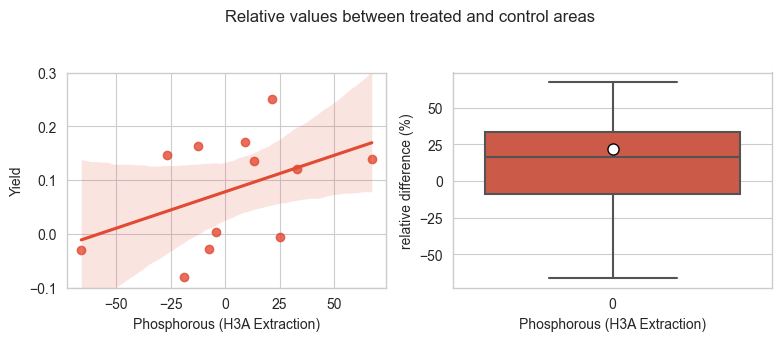

In [32]:
plA("Yield", "Phosphorous (H3A Extraction)")

### As we saw before, the treatment increase availability (box plot) and there is a positive correlation between yield differences between treated and control areas and availability of phosphorous in treated versus control areas.

However: could there bew cases of "availability saturation"? 

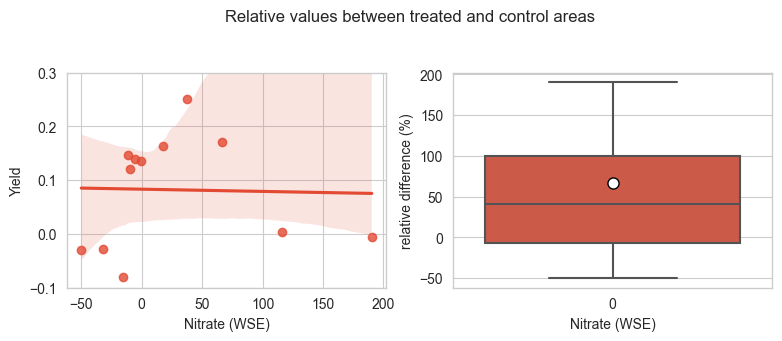

In [33]:
plA("Yield", "Nitrate (WSE)")

### This is an interesting example: areas trated clearly show a trend of higher nitrate availability versus control areas (boxplot). However, there is a weak relationship between higher availability of nitrate and yield differences between treated and control areas. 

Therefore, simply having a nutrient more available does not necessarily mean a higher yield. We know this is true, as at some stage there is a saturation. In such cases, the treatment works as an "insurance", meaning that if there is uncertainty on the nutrient availability, having this treatment decreases the chance of lacking nutrient and thus lower yields.  

### Since we are looking into the macro-nutrients, how does this graph looks like for K?

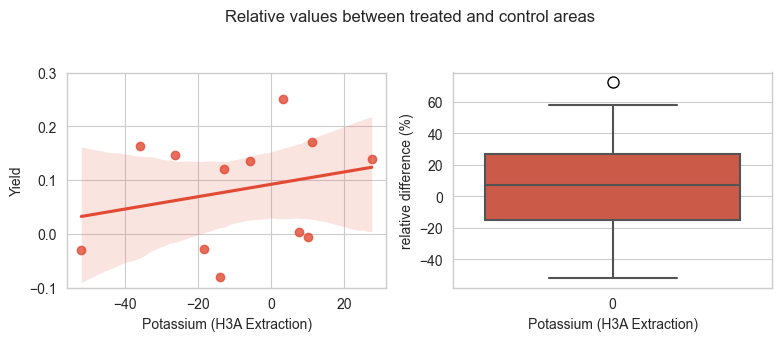

In [34]:
plA("Yield", "Potassium (H3A Extraction)")

## Let us finally look at the parameters with highest regression fits

In [35]:
# use this to create a list of relevant parameters that we want to cross with yield
df_comb.index

Index(['Yield', 'Farm', 'Crop', 'Rate (lb/ac)', 'OM', 'pH', 'Nitrate N',
       'Po4P of pH > 6', 'Potassium', 'Magnesium', 'Calcium', 'Manganese',
       'Copper', 'Iron', 'Boron', 'Potassium (CEC)', 'Magnesium (CEC)',
       'Calcium (CEC)', 'Total CEC (CEC)', 'EC (conductivity)',
       'Fizz Test (conductivity)', 'Phosphorous (H3A Extraction)',
       'Potassium (H3A Extraction)', 'Magnesium (H3A Extraction)',
       'Calcium (H3A Extraction)', 'Sodium (H3A Extraction)',
       'Iron (H3A Extraction)', 'Aluminum (H3A Extraction)', 'Nitrate (WSE)',
       'Ammonical Nitogen (WSE)', 'Orthophosphate-P (WSE)', 'Carbon (WSE)',
       'Total Nitrogen (WSE)', 'CO2C Burst (Haney)', 'Organic carbon (Haney)',
       'Organic nitrogen (Haney)', 'Organic C/N ration (Haney)', 'Haney Test',
       'Nitrogen Credit via Haney'],
      dtype='object')

In [36]:
# create a list of parameters that we are interested to check versus yield 
# (relative results in treated versus control areas)
# take out parameters with too many or only nan values (spurious results)

par = ['Nitrate N', 'Po4P of pH > 6',
       'Potassium', 'Magnesium', 'Calcium',
       'Manganese', 'Copper', 'Iron', 'Boron', 'Potassium (CEC)',
       'Magnesium (CEC)', 'Calcium (CEC)',
       'Total CEC (CEC)', 'EC (conductivity)', 'Fizz Test (conductivity)',
       'Phosphorous (H3A Extraction)', 'Potassium (H3A Extraction)',
       'Magnesium (H3A Extraction)', 'Calcium (H3A Extraction)',
       'Sodium (H3A Extraction)', 'Iron (H3A Extraction)',
       'Aluminum (H3A Extraction)', 'Nitrate (WSE)', 'Ammonical Nitogen (WSE)',
       'Orthophosphate-P (WSE)', 'Carbon (WSE)', 'Total Nitrogen (WSE)',
       'CO2C Burst (Haney)', 'Organic carbon (Haney)',
       'Organic nitrogen (Haney)', 'Organic C/N ration (Haney)', 'Haney Test',
       'Nitrogen Credit via Haney']

In [37]:
# create a list with the values of a simple regression of the data (rel. parameter, rel. yield)
# where parameter comes from the list 'par' defined above

corl = []

for i in par:
    ry = "Yield"
    rx = i

    #print(i)
    # clean the data (get rid of nan)
    w_df = pd.DataFrame()
    w_df = df_comb.T[[rx,ry]].copy()
    w_df.reset_index(inplace=True, drop=True)
    w_df.dropna(axis=0, how="any",inplace=True)
    w_df = w_df.astype(float)

    # use a simple linear regression - use all data point, as we do not have that many...
    regr = linear_model.LinearRegression()
    train_x = np.asanyarray(w_df[[rx]])
    train_y = np.asanyarray(w_df[[ry]])
    regr.fit(train_x, train_y)
    test_y_ = regr.predict(train_x)
    
    corl = corl + [[rx, regr.coef_[0,0], regr.intercept_[0], r2_score(train_y , test_y_)]]

In [38]:
corl[0:3]

[['Nitrate N',
  -0.0014274910729836939,
  0.11076304740522155,
  0.1824843894900502],
 ['Po4P of pH > 6',
  0.0004464841437394353,
  0.09447317401915686,
  0.0059173214976591115],
 ['Potassium',
  -0.0019049328342382386,
  0.07645850488364055,
  0.0702431007741533]]

In [39]:
# set a dataframe with the diferent parameters and their respective regression 
# values with rel. yield diff. as y-axis 
pd.options.display.float_format = '{:,.5f}'.format
df_corl = pd.DataFrame(corl, columns=["parameter","slope","intercept","R2"])
df_corl.head()

,parameter,slope,intercept,R2
0,Nitrate N,-0.00143,0.11076,0.18248
1,Po4P of pH > 6,0.00045,0.09447,0.00592
2,Potassium,-0.00190,0.07646,0.07024
3,Magnesium,-0.00098,0.07965,0.01490
4,Calcium,-0.00160,0.07621,0.00949


### Focus on the parameters that have R2 > 0.1 (both with postive and negative slopes)

In [40]:
# get the top parameters correlate positively with rel. yield diff. (ordered by fit to the regression)
df_pos = df_corl[df_corl["slope"] >= 0.0].sort_values(by="R2", ascending = False).reset_index(drop = True)
df_pos_top = df_pos[df_pos["R2"] > 0.1]
df_pos_top

,parameter,slope,intercept,R2
0,Nitrogen Credit via Haney,0.00126,0.09277,0.21298
1,Phosphorous (H3A Extraction),0.00135,0.07836,0.19348
2,Organic nitrogen (Haney),0.00083,0.08430,0.10550


#### These parameters have the highest fit (measured through R2) as linear relation between yield difference and parameter difference between treated and control areas

In [41]:
# get the top parameters correlate negatively with yield (ordered by fit to the regression)
df_neg = df_corl[df_corl["slope"] < 0.0].sort_values(by="R2", ascending = False).reset_index(drop = True)
df_neg_top = df_neg[df_neg["R2"] > 0.1]
df_neg_top

,parameter,slope,intercept,R2
0,EC (conductivity),-0.00193,0.10997,0.21144
1,Nitrate N,-0.00143,0.11076,0.18248
2,Organic C/N ration (Haney),-0.00032,0.10712,0.17992


#### These parameters have the highest fit (measured through R2) as negative linear relation between yield difference and parameter difference between treated and control areas

#### At this stage we will stop this analysis. Having identified these parameters we would need to go for a deep dive to understand what the relations are, etc. 